# Recommender System Exploration: PyTorch

Team Members:Rachael Burris, Emily Luskind, Melanie Tran

Pytorch Model Development:Rachael

### Install and Load packages

In [ ]:
#!pip install pytorch-lightning

In [137]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

## PyTorch
import torch
from torch.utils.data import Dataset
import torch.nn as nn
from torch.utils.data import DataLoader
import pytorch_lightning as pl
import torchmetrics
from pytorch_lightning.callbacks import ModelCheckpoint
import pytorch_lightning

## additional needs ##
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.callbacks import TensorBoard
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
import collections
from collections import OrderedDict

## plotting
from sklearn.manifold import TSNE



### Mount Drive and Load Data

In [128]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [129]:
path='/content/drive/Shareddrives/MachineLearningFinal/'

df = pd.read_csv(path+"beer_reviews.csv")
df.head()

,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid
0,10325,Vecchio Birraio,1234817823,1.5,2.0,2.5,stcules,Hefeweizen,1.5,1.5,Sausa Weizen,5.0,47986
1,10325,Vecchio Birraio,1235915097,3.0,2.5,3.0,stcules,English Strong Ale,3.0,3.0,Red Moon,6.2,48213
2,10325,Vecchio Birraio,1235916604,3.0,2.5,3.0,stcules,Foreign / Export Stout,3.0,3.0,Black Horse Black Beer,6.5,48215
3,10325,Vecchio Birraio,1234725145,3.0,3.0,3.5,stcules,German Pilsener,2.5,3.0,Sausa Pils,5.0,47969
4,1075,Caldera Brewing Company,1293735206,4.0,4.5,4.0,johnmichaelsen,American Double / Imperial IPA,4.0,4.5,Cauldron DIPA,7.7,64883


In [130]:
beer_lookup_table=df[['beer_beerid','beer_name']]
beer_lookup_table=beer_lookup_table.drop_duplicates()   ##for returning beer names based on ID later

In [131]:
df.head()

,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid
0,10325,Vecchio Birraio,1234817823,1.5,2.0,2.5,stcules,Hefeweizen,1.5,1.5,Sausa Weizen,5.0,47986
1,10325,Vecchio Birraio,1235915097,3.0,2.5,3.0,stcules,English Strong Ale,3.0,3.0,Red Moon,6.2,48213
2,10325,Vecchio Birraio,1235916604,3.0,2.5,3.0,stcules,Foreign / Export Stout,3.0,3.0,Black Horse Black Beer,6.5,48215
3,10325,Vecchio Birraio,1234725145,3.0,3.0,3.5,stcules,German Pilsener,2.5,3.0,Sausa Pils,5.0,47969
4,1075,Caldera Brewing Company,1293735206,4.0,4.5,4.0,johnmichaelsen,American Double / Imperial IPA,4.0,4.5,Cauldron DIPA,7.7,64883


# EDA

In [132]:
top_styles=df.beer_style.value_counts()[:7]
top_styles

American IPA                        117586
American Double / Imperial IPA       85977
American Pale Ale (APA)              63469
Russian Imperial Stout               54129
American Double / Imperial Stout     50705
American Porter                      50477
American Amber / Red Ale             45751
Name: beer_style, dtype: int64

In [133]:
nums=df[['review_overall','review_aroma','review_appearance','review_palate','review_taste','beer_style']]

In [134]:
top_nums=nums[nums['beer_style'].isin(top_styles.index)]

In [135]:
top_nums=top_nums.melt(value_vars=['review_overall','review_aroma','review_appearance','review_palate','review_taste'], id_vars=['beer_style'])
top_nums.columns=(['Beer Style','Review Type','Rating'])

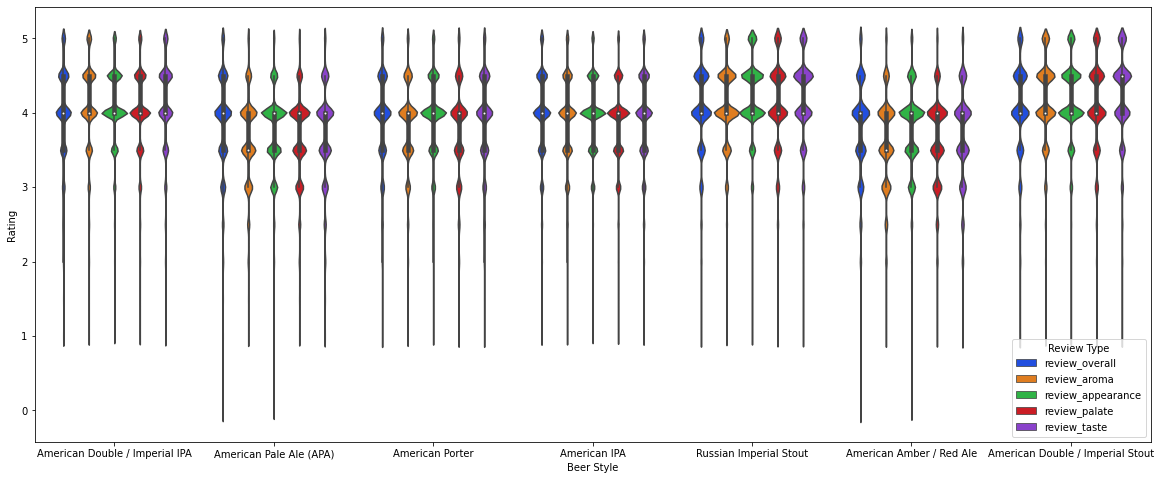

In [138]:
plt.figure(figsize=(20,8))

sns.violinplot(data=top_nums,y='Rating',x='Beer Style',hue='Review Type',palette='bright')

In [139]:
top_nums.groupby('Beer Style').describe()

Rating                      ...               
                                     count      mean       std  ...  50%  75%  max
Beer Style                                                      ...               
American Amber / Red Ale          228755.0  3.714255  0.627636  ...  4.0  4.0  5.0
American Double / Imperial IPA    429885.0  4.057825  0.571073  ...  4.0  4.5  5.0
American Double / Imperial Stout  253525.0  4.128003  0.606099  ...  4.0  4.5  5.0
American IPA                      587930.0  3.923538  0.573286  ...  4.0  4.5  5.0
American Pale Ale (APA)           317345.0  3.739448  0.609848  ...  4.0  4.0  5.0
American Porter                   252385.0  3.874420  0.605380  ...  4.0  4.0  5.0
Russian Imperial Stout            270645.0  4.109245  0.590188  ...  4.0  4.5  5.0

[7 rows x 8 columns]

In [147]:
print('Unique Styles of beer:  ',len(df.beer_style.unique()))
print('Unique Names of beer:   ',len(df.beer_name.unique()))
print('Unique Users:           ',len(df.review_profilename.unique()))
print('Total Reviews:          ',len(df))

Unique Styles of beer:   104
Unique Names of beer:    56857
Unique Users:            33388
Total Reviews:           1586614


# Model Prep

In [148]:
df=df[['beer_beerid','review_overall','review_profilename','review_time']]  # keep only neccessary columns

In [149]:
names = df['review_profilename']    # create user ids
codes, uniques = pd.factorize(names)
df['user_id'] = codes

In [150]:
#create train and test using leave one out method
df['rank_latest'] = df.groupby(['user_id'])['review_time'].rank(method='first', ascending=False)

train = df[df['rank_latest'] != 1]
test = df[df['rank_latest'] == 1]

# drop columns that we no longer need
train = train[['user_id', 'beer_beerid', 'review_overall']]
test = test[['user_id', 'beer_beerid', 'review_overall']]

In [151]:
train.loc[:, 'review_overall'] = 1

In [152]:
x=train[train.user_id < 0].index
y=test[test.user_id < 0].index
train=train.drop(x,axis=0 )
test=test.drop(y,axis=0 )

In [154]:
# Get a list of all movie IDs
all_beerIds = df['beer_beerid'].unique()

# Placeholders that will hold the training data
users, items, labels = [], [], []

# This is the set of items that each user has interaction with
user_item_set = set(zip(train['user_id'], train['beer_beerid']))

# 4:1 ratio of negative to positive samples
num_negatives = 4

for (u, i) in user_item_set:
    users.append(u)
    items.append(i)
    labels.append(1) # items that the user has interacted with are positive
    for _ in range(num_negatives):
        # randomly select an item
        negative_item = np.random.choice(all_beerIds) 
        # check that the user has not interacted with this item
        while (u, negative_item) in user_item_set:
            negative_item = np.random.choice(all_beerIds)
        users.append(u)
        items.append(negative_item)
        labels.append(0) # items not interacted with are negative

# PyTorch Lightning

 from TDS https://towardsdatascience.com/deep-learning-based-recommender-systems-3d120201db7e

## Functions

In [12]:
class TrainDataset(Dataset):
    """
    Args:
        df (pd.DataFrame): Dataframe containing the beer df
        all_beerIds (list): List containing all beerIds
    
    """
    def __init__(self, df, all_beerIds):
        self.users, self.items, self.labels = self.get_dataset(df, all_beerIds)

    def __len__(self):
        return len(self.users)
  
    def __getitem__(self, idx):
        return self.users[idx], self.items[idx], self.labels[idx]

    def get_dataset(self, df, all_beerIds):
        users, items, labels = [], [], []
        user_item_set = set(zip(df['user_id'], df['beer_beerid']))

        num_negatives = 4
        for u, i in user_item_set:
            users.append(u)
            items.append(i)
            labels.append(1)
            for _ in range(num_negatives):
                negative_item = np.random.choice(all_beerIds)
                while (u, negative_item) in user_item_set:
                    negative_item = np.random.choice(all_beerIds)
                users.append(u)
                items.append(negative_item)
                labels.append(0)

        return torch.tensor(users), torch.tensor(items), torch.tensor(labels)

class ValDataset(Dataset):
    """
    Args:
        df (pd.DataFrame): Dataframe containing the beer df
        all_beerIds (list): List containing all beerIds
    
    """

    def __init__(self, df, all_beerIds):
        self.users, self.items, self.labels = self.get_dataset(df, all_beerIds)

    def __len__(self):
        return len(self.users)
  
    def __getitem__(self, idx):
        return self.users[idx], self.items[idx], self.labels[idx]

    def get_dataset(self, df, all_beerIds):
        users, items, labels = [], [], []
        user_item_set = set(zip(df['user_id'], df['beer_beerid']))

        num_negatives = 4
        for u, i in user_item_set:
            users.append(u)
            items.append(i)
            labels.append(1)
            for _ in range(num_negatives):
                negative_item = np.random.choice(all_beerIds)
                while (u, negative_item) in user_item_set:
                    negative_item = np.random.choice(all_beerIds)
                users.append(u)
                items.append(negative_item)
                labels.append(0)

        return torch.tensor(users), torch.tensor(items), torch.tensor(labels)

In [18]:
from pytorch_lightning import loggers as pl_loggers

tb_logger = pl_loggers.TensorBoardLogger("logs/")


In [13]:
class NCF(pl.LightningModule):
    """ Neural Collaborative Filtering (NCF)
    
        Args:
            num_users (int): Number of unique users
            num_items (int): Number of unique items
            df (pd.DataFrame): Dataframe containing the beer ratings for training
            all_beerIds (list): List containing all beerIds (train + test)
    """
    
    def __init__(self, num_users, num_items, train, test, all_beerIds):
        super().__init__()
        self.user_embedding = nn.Embedding(num_embeddings=num_users, embedding_dim=8)
        self.item_embedding = nn.Embedding(num_embeddings=num_items, embedding_dim=8)
        self.fc1 = nn.Linear(in_features=16, out_features=64)
        self.fc2 = nn.Linear(in_features=64, out_features=32)
        self.output = nn.Linear(in_features=32, out_features=1)
        self.ratings = train
        self.test = test
        self.all_beerIds = all_beerIds
        self.train_acc = torchmetrics.MeanSquaredError(squared=False) #added
        self.valid_acc = torchmetrics.MeanSquaredError(squared=False) #added

        
    def forward(self, user_input, item_input):
        
        # Pass through embedding layers
        user_embedded = self.user_embedding(user_input)
        item_embedded = self.item_embedding(item_input)

        # Concat the two embedding layers
        vector = torch.cat([user_embedded, item_embedded], dim=1)

        # Pass through dense layer
        vector = nn.ReLU()(self.fc1(vector))
        vector = nn.ReLU()(self.fc2(vector))

        # Output layer
        pred = nn.Sigmoid()(self.output(vector))

        return pred
    
    def training_step(self, batch, batch_idx):
        user_input, item_input, labels = batch
        predicted_labels = self(user_input, item_input)
        loss = nn.MSELoss()(predicted_labels, labels.view(-1, 1).float())
        self.log("train_loss", loss, prog_bar=True, sync_dist=True, logger=True)                                     #
        self.log('train_acc',self.train_acc(predicted_labels,labels.view(-1, 1).float()))                 #
        return loss
      
    def training_epoch_end(self,outs):
      self.log('train_acc_epoc',self.train_acc.compute(),prog_bar=True, logger=True)

    def validation_step(self, batch, batch_idx):
        user_input, item_input, labels = batch
        predicted_labels = self(user_input, item_input) 
        val_rmse=self.valid_acc(predicted_labels,labels.view(-1, 1).float())
        self.log('valid_acc',self.valid_acc(predicted_labels,labels.view(-1, 1).float()), prog_bar=True, logger=True)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters())

    def train_dataloader(self):
        return DataLoader(TrainDataset(self.ratings, self.all_beerIds),
                          batch_size=5000, num_workers=4)
    def val_dataloader(self):
        return DataLoader(ValDataset(self.test, self.all_beerIds),
                          batch_size=5000, num_workers=4)


In [155]:
def PyEvaluator(model,train,test):
  # User-item pairs for testing
  test_user_item_set = set(zip(test['user_id'], test['beer_beerid']))

    # Dict of all items that are interacted with by each user
  user_interacted_items = df.groupby('user_id')['beer_beerid'].apply(list).to_dict()

  hits = []
  results= pd.DataFrame(test_user_item_set)
  results.columns=['User ID','Beer ID']
  results['Top10']=""

  for (u,i) in test_user_item_set:
      interacted_items = user_interacted_items[u]
      not_interacted_items = set(all_beerIds) - set(interacted_items)
      selected_not_interacted = list(np.random.choice(list(not_interacted_items), 99))
      test_items = selected_not_interacted + [i]
      
      predicted_labels = np.squeeze(model(torch.tensor([u]*100), 
                                          torch.tensor(test_items)).detach().numpy())
      
      top10_items = [test_items[i] for i in np.argsort(predicted_labels)[::-1][0:10].tolist()]

      results['Top10'][u]=top10_items

      if i in top10_items:
          hits.append(1)
      else:
          hits.append(0)

  print("The Hit Ratio @ 10 is {:.2f}".format(np.average(hits)))
  return hits, results

In [103]:
def GetRecs(user_id):
  x = results[results['User ID'].isin([user_id])].Top10
  recs = beer_lookup_table[beer_lookup_table['beer_beerid'].isin(x.values[0])]
  user_reviews=df[df['user_id'].isin([user_id])]
  hits=user_reviews[user_reviews['beer_beerid'].isin(x.values[0])]
  return recs,hits

## Training



In [16]:
callbacks= [pl.callbacks.ModelCheckpoint(path+'M5best', save_top_k=1)]

In [19]:
num_users = df['user_id'].max()+1
num_items = df['beer_beerid'].max()+1
all_beerIds = df['beer_beerid'].unique()

model = NCF(num_users, num_items, train, test, all_beerIds)

trainer = pl.Trainer(max_epochs=5, gpus=1, reload_dataloaders_every_n_epochs=True, 
                     progress_bar_refresh_rate=50, logger=tb_logger, callbacks=callbacks)



GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [20]:
M1=trainer.fit(model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type             | Params
----------------------------------------------------
0 | user_embedding | Embedding        | 267 K 
1 | item_embedding | Embedding        | 618 K 
2 | fc1            | Linear           | 1.1 K 
3 | fc2            | Linear           | 2.1 K 
4 | output         | Linear           | 33    
5 | train_acc      | MeanSquaredError | 0     
6 | valid_acc      | MeanSquaredError | 0     
----------------------------------------------------
888 K     Trainable params
0         Non-trainable params
888 K     Total params
3.555     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [21]:
##access the training log
trainer.logged_metrics


{'epoch': 4,
 'train_acc': tensor(0.2546),
 'train_acc_epoc': 0.28140589594841003,
 'train_loss': tensor(0.0648),
 'valid_acc': 0.2668040096759796}

## Store and Load

model log -   
v1-4: rmse not reporting train and/or val steps  
v5: rmse reporting on both. 5 epochs (.264 train, .267 val, .83 hit)  
v6: 6 epochs (train .2558, .266 val)

In [22]:
PATH = path+"PyTorchModelv5.pt"

# Save
torch.save(model.state_dict(), PATH)

model v6 is overfitting, as the val rmse is higher than the train and our hit score went down. will reload previous version trained on 5 epochs.

In [38]:
#Load
PATH = path+"PyTorchModelv5.pt"
device = torch.device('cpu')
model = NCF(num_users, num_items, df,test,all_beerIds)
model.load_state_dict(torch.load(PATH, map_location=device))

<All keys matched successfully>

## Evaluate

In [156]:
PyEvaluator(model,train,test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


The Hit Ratio @ 10 is 0.82


([1,
  1,
  0,
  0,
  1,
  1,
  1,
  1,
  0,
  1,
  0,
  1,
  0,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  0,
  1,
  0,
  1,
  1,
  1,
  1,
  0,
  0,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  0,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  1,
  0,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  0,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  0,
  0,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  0,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,


In [157]:
recs,hits = GetRecs(3)
hits

,beer_beerid,review_overall,review_profilename,review_time,user_id,rank_latest
72250,40492,4.0,Reidrover,1204003646,3,364.0
640257,9689,3.0,Reidrover,1141186919,3,579.0
1149465,733,4.5,Reidrover,1042833344,3,1281.0
1323108,63,4.0,Reidrover,1056144128,3,1072.0


In [158]:
recs

,beer_beerid,beer_name
46024,40492,Sierra Nevada ESB (Early Spring Beer)
121466,52281,Sweetwater Dank Tank Big Ol' Belgian Blue Balls
544651,41815,Parabola
622231,9689,White Rascal
753240,28942,Solstice
1049493,65519,Leinenkugel's Limited Golden Lager
1083277,1710,Oude Gueuze
1149431,733,Fuller's India Pale Ale
1283727,63,Anchor Steam Beer
1397912,55019,Hoppy Feet


# Keras

from https://towardsdatascience.com/recommender-systems-from-learned-embeddings-f1d12288f278

## Functions

In [159]:
def EmbeddingRec(EMBEDDING_SIZE, NUM_MOVIES, NUM_USERS, ROW_COUNT):
    movie_input = keras.Input(shape=(1,), name='movie_id')

    movie_emb = layers.Embedding(output_dim=EMBEDDING_SIZE, input_dim=NUM_MOVIES, input_length=ROW_COUNT, name='movie_emb')(movie_input)
    movie_vec = layers.Flatten(name='FlattenMovie')(movie_emb)

    movie_model = keras.Model(inputs=movie_input, outputs=movie_vec)
    
    user_input = keras.Input(shape=(1,), name='user_id')

    user_emb = layers.Embedding(output_dim=EMBEDDING_SIZE, input_dim=NUM_USERS, input_length=ROW_COUNT, name='user_emb')(user_input)
    user_vec = layers.Flatten(name='FlattenUser')(user_emb)

    user_model = keras.Model(inputs=user_input, outputs=user_vec)
    
    merged = layers.Dot(name = 'dot_product', normalize = True, axes = 2)([movie_emb, user_emb])
    merged_dropout = layers.Dropout(0.2)(merged)
    
    
    dense_1 = layers.Dense(70,name='FullyConnected-1')(merged)
    dropout_1 = layers.Dropout(0.2,name='Dropout_1')(dense_1)

    dense_2 = layers.Dense(50,name='FullyConnected-2')(dropout_1)
    dropout_2 = layers.Dropout(0.2,name='Dropout_2')(dense_2)

    dense_3 = keras.layers.Dense(20,name='FullyConnected-3')(dropout_2)
    dropout_3 = keras.layers.Dropout(0.2,name='Dropout_3')(dense_3)

    dense_4 = keras.layers.Dense(10,name='FullyConnected-4', activation='relu')(dropout_3)

    result = layers.Dense(1, name='result', activation="relu") (dense_4)

    adam = keras.optimizers.Adam(learning_rate=0.001)
    model = keras.Model([movie_input, user_input], result)
    model.compile(optimizer=adam,loss= 'mean_absolute_error')
    return model, movie_model, user_model

In [160]:
## adjusted language
def EmbeddingRec(emb_size, num_items, num_users, train):
    row_count=len(train)
    beer_input = keras.Input(shape=(1,), name='beer_id')

    beer_emb = layers.Embedding(output_dim=emb_size, input_dim=num_items, input_length=row_count, name='beer_emb')(beer_input)
    beer_vec = layers.Flatten(name='FlattenBeer')(beer_emb)

    beer_model = keras.Model(inputs=beer_input, outputs=beer_vec)
    
    user_input = keras.Input(shape=(1,), name='user_id')

    user_emb = layers.Embedding(output_dim=emb_size, input_dim=num_users, input_length=row_count, name='user_emb')(user_input)
    user_vec = layers.Flatten(name='FlattenUser')(user_emb)

    user_model = keras.Model(inputs=user_input, outputs=user_vec)
    
    merged = layers.Dot(name = 'dot_product', normalize = True, axes = 2)([beer_emb, user_emb])
    merged_dropout = layers.Dropout(0.2)(merged)
    
    
    dense_1 = layers.Dense(70,name='FullyConnected-1')(merged)
    dropout_1 = layers.Dropout(0.2,name='Dropout_1')(dense_1)

    dense_2 = layers.Dense(50,name='FullyConnected-2')(dropout_1)
    dropout_2 = layers.Dropout(0.2,name='Dropout_2')(dense_2)

    dense_3 = keras.layers.Dense(20,name='FullyConnected-3')(dropout_2)
    dropout_3 = keras.layers.Dropout(0.2,name='Dropout_3')(dense_3)

    dense_4 = keras.layers.Dense(10,name='FullyConnected-4', activation='relu')(dropout_3)

    result = layers.Dense(1, name='result', activation="relu") (dense_4)

    adam = keras.optimizers.Adam(learning_rate=0.001)
    model = keras.Model([beer_input, user_input], result)
    model.compile(optimizer=adam,loss= 'mean_absolute_error', metrics= tf.keras.metrics.RootMeanSquaredError())
    return model, beer_model, user_model

In [161]:
def KerasEvaluate(model,train,test): #numpy version
    pred = model.predict(test)
    a=pred.argsort(axis=1) #ascending, sort by row, return index
    a = np.fliplr(a) #reverse to get descending
    a = a[:,0:10] #return only the first 10 columns of each row
    Ybool = [] #initialze 2D arrray
    for t, idx in enumerate(a):
        ybool = np.zeros(num_items +1) #zero fill; 0 index is reserved
        ybool[idx] = 1 #flip the recommended item from 0 to 1
        Ybool.append(ybool)
    A = map(lambda t: list(t), Ybool)
    right_sum = (A * test).max(axis=1) #element-wise multiplication, then find the max
    right_sum = right_sum.sum() #how many times did we score a hit?
    return right_sum/len(test) #fraction of observations where we scored a hit

In [163]:
def KerasEvaluator(model,train,test):
  test_user_item_set = set(zip(test['user_id'], test['beer_beerid']))

  # Dict of all items that are interacted with by each user
  user_interacted_items = df.groupby('user_id')['beer_beerid'].apply(list).to_dict()

  hits = []

  for (u,i) in test_user_item_set:
      interacted_items = user_interacted_items[u]
      not_interacted_items = set(all_beerIds) - set(interacted_items)
      selected_not_interacted = list(np.random.choice(list(not_interacted_items), 99))
      test_items = selected_not_interacted + [i]
      
      predicted_labels = user_model.predict([u]).reshape(1,-1)[0]
      
      top10_items = [test_items[i] for i in np.argsort(predicted_labels)[0:10].tolist()]
      
      if i in top10_items:
          hits.append(1)
      else:
          hits.append(0)
          
  print("The Hit Ratio @ 10 is {:.2f}".format(np.average(hits)))

## Training

In [164]:
num_users = df['user_id'].max()+1
num_items = df['beer_beerid'].max()+1
all_beerIds = df['beer_beerid'].unique()

In [165]:
model, beer_model, user_model=EmbeddingRec(30, num_items,num_users,train)

In [ ]:
callbacks = [keras.callbacks.EarlyStopping('val_loss', patience=10),
             keras.callbacks.ModelCheckpoint('besttest', save_best_only=True)]

In [ ]:
history2 = model.fit([train.beer_beerid.values, train.user_id.values],train.review_overall.values, batch_size=1000,
                              epochs =50, validation_split =.2,
                              verbose = 1,
                              callbacks=callbacks)

Epoch 1/50
1243/1243 [==============================] - 10s 6ms/step - loss: 0.0469 - root_mean_squared_error: 0.1285 - val_loss: 3.9176e-04 - val_root_mean_squared_error: 3.9196e-04
INFO:tensorflow:Assets written to: besttest/assets
Epoch 2/50
1243/1243 [==============================] - 7s 6ms/step - loss: 3.0318e-04 - root_mean_squared_error: 3.5113e-04 - val_loss: 2.9671e-04 - val_root_mean_squared_error: 2.9688e-04
INFO:tensorflow:Assets written to: besttest/assets
Epoch 3/50
1243/1243 [==============================] - 7s 6ms/step - loss: 2.3177e-04 - root_mean_squared_error: 2.7569e-04 - val_loss: 1.7550e-04 - val_root_mean_squared_error: 1.7552e-04
INFO:tensorflow:Assets written to: besttest/assets
Epoch 4/50
1243/1243 [==============================] - 7s 6ms/step - loss: 2.1709e-04 - root_mean_squared_error: 2.3565e-04 - val_loss: 2.2874e-04 - val_root_mean_squared_error: 2.2874e-04
Epoch 5/50
1243/1243 [==============================] - 7s 6ms/step - loss: 2.1546e-04 - root_

## Save and Load

In [ ]:
# Save
#model.save(path+'KerasBest')

INFO:tensorflow:Assets written to: /content/drive/Shareddrives/MachineLearningFinal/KerasBest/assets


In [ ]:
# Load
model2 = keras.models.load_model(path+'KerasBest')

## Plot

### shape

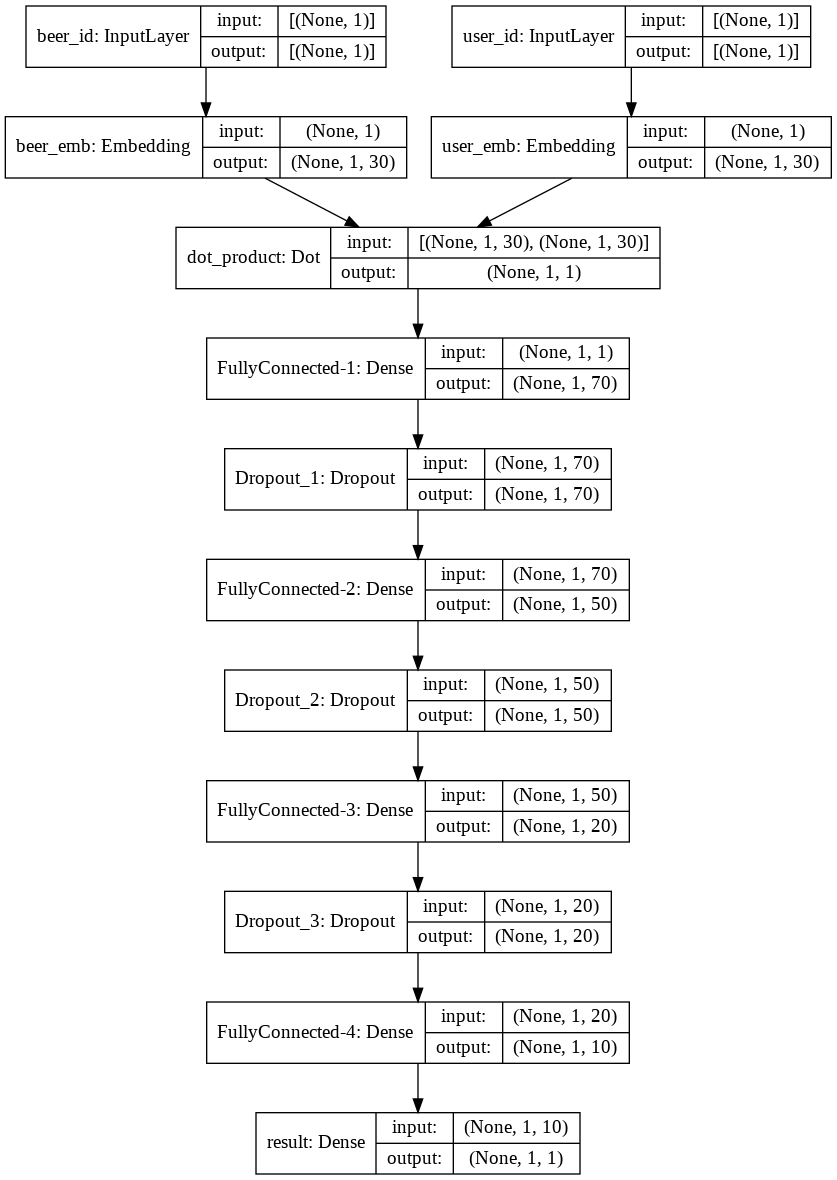

In [ ]:
keras.utils.plot_model(model2, show_shapes=True)

### loss

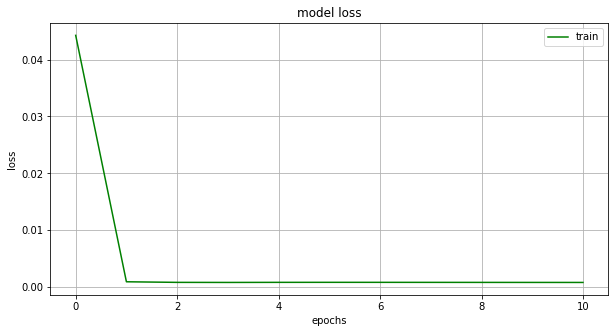

In [ ]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
import matplotlib.pyplot as plt
plt.plot(history.history['loss'] , 'g')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train'], loc='upper right')
plt.grid(True)
plt.show()

In [ ]:
# KNN recommendation
test_user_ID = 200
test_item_ID = 123

In [ ]:
import collections

In [ ]:
# extract movie embedding
item_embedding_list = []
item_embed_map = collections.defaultdict()

In [ ]:
for _id in all_beerIds:
    emb = beer_model.predict(np.array([_id]))
    val = list(emb.reshape(1,-1))[0]
    item_embedding_list.insert(_id, val)
    item_embed_map[_id] = val

## Evaluate

In [ ]:
def recommend_movies(embedding):
    distances, indices = clf.kneighbors(embedding.reshape(1, -1),  n_neighbors=10)
    indices = indices.reshape(10,1)
    df_indices = pd.DataFrame(indices, columns = ['beer_beerid'])
    return df_indices.merge(movies,on='beer_beerid',how='inner',suffixes=['_u', '_m'])['title']

In [ ]:
predicted_labels[0:10]

array([-0.03561769, -0.02516875, -0.02198309,  0.03436101,  0.00890581,
       -0.02451243, -0.02196512, -0.00550046,  0.01557272, -0.02845438],
      dtype=float32)

In [ ]:
  for (u,i) in test_user_item_set:
      interacted_items = user_interacted_items[u]
      not_interacted_items = set(all_beerIds) - set(interacted_items)
      selected_not_interacted = list(np.random.choice(list(not_interacted_items), 99))
      test_items = selected_not_interacted + [i]
      
      predicted_labels = user_model.predict([u]).reshape(1,-1)[0]
      
      top10_items = [test_items[i] for i in np.argsort(predicted_labels)[0:10].tolist()]
      
      if i in top10_items:
          hits.append(1)
      else:
          hits.append(0)
          
  print("The Hit Ratio @ 10 is {:.2f}".format(np.average(hits)))

The Hit Ratio @ 10 is 0.00


In [ ]:
def tsne_plot(model, item_embedding_list, size = num_items):
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(item_embedding_list[:size])
    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
    labels = list(range(0,size))
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],xy=(x[i], y[i]),xytext=(5, 2),textcoords='offset points',ha='right',va='bottom')
    plt.show()